# Advanced Lane Lines

In [1]:
%matplotlib inline
"""
Implementation of Advanced Lane Line detection
"""
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip


class Image():
    """
    Basic container class for image with common image functions.
    """
    def __init__(self, path=None, image=None, colorspace="RGB",
                annotate_pos=(100, 100)):
        """
        Init function. Takes a path or a pre-read image
        """
        if path:
            self.path = path
            self.image = mpimg.imread(path)
            self.colorspace = "BGR"
        else:
            self.image = image
            self.colorspace = colorspace     
        self.annotate_pos = annotate_pos
        
    def gray(self):
        """
        convert to grayscale
        """
        if self.colorspace == "gray":
            return self.image
        elif self.colorspace == "BGR":
            gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        else:
            gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        return gray

    def hls(self):
        """
        convert to hls colorspace
        """
        if self.colorspace == "gray":
            raise Exception("no HLS for gray colorspace")
        elif self.colorspace == "BGR":
            hls = cv2.cvtColor(self.image, cv2.COLOR_BGR2HLS)
        else:
            hls = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
        return hls
    
    def hls_select(self, thresh=(0, 255)):
        """
        select S channel and binarize the image based on threhold
        """
        hls = self.hls()
        S = hls[:,:,2]
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        return binary

    def abs_sobel_thresh(self, ksize=3, thresh=(0, 255), orient='x'):
        """
        binarize image based on sobel threshold and orientation
        """
        # Apply the following steps to img
        if orient == 'x':
            sobel = cv2.Sobel(self.gray(), cv2.CV_64F, 1, 0, ksize=ksize)
        else:
            sobel = cv2.Sobel(self.gray(), cv2.CV_64F, 0, 1, ksize=ksize)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary

    def mag_thresh(self, ksize=3, thresh=(0, 255)):
        """
        binarize based on threshold applied to squareroot of 
        sum of squares of sobel in both orientations 
        """
        gray = self.gray()
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        magnitude = np.sqrt(sobelx**2 + sobely**2)
        scaled_mag = np.uint8(255*magnitude/np.max(magnitude))
        binary = np.zeros_like(magnitude)
        binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
        return binary

    def dir_threshold(self, ksize=3, thresh=(0, np.pi/2)):
        """
        binarize based on threshold applied to direction of gradient
        direction is obtained by arctan(sobelY/sobelX)
        """
        gray = self.gray()
        sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
        sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))
        direction = np.arctan2(sobely, sobelx)
        binary = np.zeros_like(direction)
        binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
        return binary    

    
    def threshold_or(self, ksize=3, absx_thresh=None, 
                     absy_thresh=None,mag_thresh=None, 
                     dir_thresh=None, hls_thresh=None):
        """
        utility function to combine (via OR operator) different
        thresholds
        """
        out = np.zeros_like(self.gray())
        if absx_thresh:
            img = self.abs_sobel_thresh(ksize=ksize, thresh=absx_thresh)
            out[img > 0] = 1
        if absy_thresh:
            img = self.abs_sobel_thresh(ksize=ksize, thresh=absy_thresh, orient='y')
            out[img > 0] = 1
        if mag_thresh:
            img = self.mag_thresh(ksize=ksize, thresh=mag_thresh)
            out[img > 0] = 1
        if dir_thresh:
            img = self.dir_threshold(ksize=ksize, thresh=dir_thresh)
            out[img > 0] = 1
        if hls_thresh:
            img = self.hls_select(thresh=hls_thresh)
            out[img > 0] = 1
        return out

    def annotate(self, text, pos=None,
                font=cv2.FONT_HERSHEY_SIMPLEX,
                line_height=50, size=1, color=255):
        if pos:
            self.annotate_pos = pos
        _img = self.image
        for line in text.split("\n"):
            _img = cv2.putText(_img, line, self.annotate_pos, font, 
                               size, color)
            self.annotate_pos = (self.annotate_pos[0],
                                 self.annotate_pos[1] + line_height)
        self.image = _img
        return self

class Camera():
    """
    Camera class that can be used to calibrate, correct, 
    unwarp images.
    """
    def __init__(self, width, height):
        """
        init camera with image dimensions
        """
        self.calibrated = False
        self.width = width
        self.height = height
        self.M = None
        self.M_inverse = None
    
    def calibrate(self, nx, ny, image_path=None, images=None):
        """
        calibrate using chessboard images taken with the camera
        """
        if image_path:
            images = glob.glob('camera_cal/calibration*.jpg')
        assert(images != None)
        
        # Calibrate the camera
        objp = np.zeros((ny * nx, 3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
            # If found, add object points, image points
            if ret:
                objpoints.append(objp)
                imgpoints.append(corners)
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = \
                  cv2.calibrateCamera(objpoints, imgpoints,
                                      (self.width, self.height), 
                                      None, None)  
        if not ret:
            raise Exception("unable to calibrate camera")
        self.calibrated = True

    def set_perspective_abs(self, src, dst=None, 
                            offsetx=0, offsety=0):
        """
        set the perpective of the camera for unwarping images
        based on absolute images pixel positions
        """
        if dst is None:
            dst = [[offsetx, camera.height-offsety], 
                   [camera.width-offsetx, camera.height-offsety],
                   [offsetx,offsety], 
                   [camera.width-offsetx,offsety]]
        src = np.float32(src)
        dst = np.float32(dst)
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inverse = cv2.getPerspectiveTransform(dst, src)

    def set_perspective_rel(self, src, dst=None,
                            offsetx=0.0, offsety=0.0):
        """
        set the perpective of the camera for unwarping images
        based on relative image position
        """
        src = [[p[0]*camera.width, p[1]*camera.height] for p in src]
        if dst:
            dst = [[p[0]*camera.width, p[1]*camera.height] for p in dst]
        offsetx *= camera.width
        offsety *= camera.height        
        self.set_perspective_abs(src, dst, offsetx, offsety)

    def _save_image_transformation(self, orig, transformed, path, cmap=None):
        """
        utility to display and record transformed images
        """
        fig = plt.figure(figsize = (10,3))
        plot = fig.add_subplot(1,2,1)
        plot.imshow(orig)
        plot = fig.add_subplot(1,2,2)
        plot.imshow(transformed, cmap=cmap)
        fig.savefig(path)
        plt.show()

    def correct_distortion(self, img, savepath=None):
        """
        correct distortion based on calibration dst, mtx
        """
        assert(self.calibrated is not None)
        orig = img.image
        undistort = cv2.undistort(orig, self.mtx, self.dist, 
                                  None, self.mtx)
        if savepath:
            self._save_image_transformation(orig, undistort, 
                                            savepath)
        return Image(image=undistort, colorspace=img.colorspace)
    
    def unwarp(self, img, savepath=None):
        """
        unwarp image based on camera perspective
        """
        assert(self.M is not None)
        orig = img.image
        dim = (orig.shape[1], orig.shape[0])
        warped = cv2.warpPerspective(orig, self.M, dim, 
                                     flags=cv2.INTER_LINEAR)
        if savepath:
            self._save_image_transformation(orig, warped, 
                                            savepath)
        return Image(image=warped, colorspace=img.colorspace)

    def warp(self, img, savepath=None):
        """
        warp image based on camera perspective
        """
        assert(self.M_inverse is not None)
        orig = img.image
        dim = (orig.shape[1], orig.shape[0])
        warped = cv2.warpPerspective(orig, self.M_inverse, dim)
        if savepath:
            self._save_image_transformation(orig, warped,
                                            savepath)
        return Image(image=warped, colorspace=img.colorspace)
    
    def threshold_or(self, img, savepath=None, **kwargs):
        """
        camera utility to apply thresholding to Image instance
        """
        orig = img.image
        thrsh = img.threshold_or(**kwargs)
        #thrsh[thrsh>0] = 255
        if savepath:
            self._save_image_transformation(orig, thrsh, 
                                            savepath, cmap="gray")
        return Image(image=thrsh, colorspace="gray")



class Line():
    """
    Class to handle lane-line calculation and tracking from video 
    frames
    
    This involves measuring how long and wide the section of lane is 
    that we're projecting in our warped image. We could do this in 
    detail by measuring out the physical lane in the field of view of 
    the camera, but for this project, you can assume that if you're 
    projecting a section of lane similar to the images above, the lane 
    is about 30 meters long and 3.7 meters wide. Or, if you prefer to 
    derive a conversion from pixel space to world space in your own
    images, compare your images with U.S. regulations that require a
    minimum lane width of 12 feet or 3.7 meters, and the dashed 
    lane lines are 10 feet or 3 meters long each.
    """
    def __init__(self, camera, margin=100, minpix=30, nwindows=9,
                ym_per_pix=40./720, xm_per_pix=3.7/700):
        self.frame = 0
        # Set the width of the windows +/- margin
        self.margin = margin
        # Set minimum pixels to recenter 
        self.minpix = minpix
        self.camera = camera
        self.nwindows = nwindows
        # line detected in last frame
        self.line_detected = False
        #polynomial coefficients for the most recent fit
        self.current_left_fit = None
        self.current_right_fit = None
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix
        self.left_curverad = 0
        self.right_curverad = 0
        self.lane_offset = 0
        
        # -------------------------------------------
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None

        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

    def reset(self):
        self.__init__(camera=self.camera, 
                      margin=self.margin, 
                      minpix=self.minpix,
                      nwindows=self.nwindows,
                      ym_per_pix=self.ym_per_pix,
                      xm_per_pix=self.xm_per_pix)

    def unwarp_threshold(self, image, annotate=True, threshold=True):
        img = Image(image=image, colorspace="RGB")
        undist = camera.correct_distortion(img)
        self.last_undist_img = undist
        img = camera.unwarp(undist)
        if threshold:
            img = camera.threshold_or(img, absx_thresh=(20,100), 
                                      hls_thresh=(90,255))
        self.frame += 1
        image = img.image
        if annotate:
            image = self.annotate_image(image)
        return image

    def unwarp(self, image, annotate=True):
        return self.unwarp_threshold(image, annotate=annotate, 
                                     threshold=False)
    
    def _x(self, y, coeffs):
        return coeffs[0]*y**2 + coeffs[1]*y + coeffs[2]
        
    def _annotate_and_fit(self, annotate, image,
                      nonzerox, nonzeroy,
                      left_lane_inds,
                      right_lane_inds,
                      out=None):
        # Generate x and y values for plotting
         # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix,
                                 leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix,
                                  rightx*self.xm_per_pix, 2)

        # How to detect quality of fit ?
        self.line_detected = True
        self.current_left_fit = left_fit
        self.current_right_fit = right_fit

        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        left_fitx = self._x(ploty, self.current_left_fit)
        right_fitx = self._x(ploty, self.current_right_fit)
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        self.poly_pts = np.hstack((pts_left, pts_right))
        #window_pts = np.hstack((window_l_line, np.fliplr(window_r_line)))
        
        if annotate:        
            if out is None:
                out = np.dstack((image, image, image))*255
            out[lefty, leftx] = [255, 0, 0]
            out[righty, rightx] = [0, 0, 255]
            left_fitx[left_fitx > image.shape[1]] = image.shape[1]-1
            right_fitx[right_fitx > image.shape[1]] = image.shape[1]-1
            left_fitx[left_fitx < 0] = 0
            right_fitx[right_fitx < 0] = 0
            out[np.uint32(ploty), np.uint32(left_fitx)] = [0,255,255]
            out[np.uint32(ploty), np.uint32(right_fitx)] = [0,255,255]
            #plt.imshow(out)
            #plt.plot(left_fitx, ploty, color='yellow')
            #plt.plot(right_fitx, ploty, color='yellow')
            #plt.xlim(0, image.shape[1])
            #plt.ylim(image.shape[0], 0)
            image = self.annotate_image(out)
        else:
            image = None
        return image
    
    def _poly_image_zero(self, image):
        image = self.unwarp_threshold(image, annotate=False)
        nz = image.nonzero()
        nzy = np.array(nz[0])
        nzx = np.array(nz[1])
        return image, nz, nzy, nzx
    
    def fit_lane_poly(self, image, annotate=True):
        image, nonzero, nonzeroy, nonzerox = self._poly_image_zero(image)

        # Take a histogram of the bottom half of the image
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Set height of windows
        window_height = np.int(image.shape[0]/self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        if annotate:
            # Create an output image to draw on and  visualize the result
            out_img = np.dstack((image, image, image))*255
        else:
            out_img = None
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            if annotate:
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                              (win_xleft_high,win_y_high),(0,255,0), 3) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position

            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        return self._annotate_and_fit(annotate, image,
                                      nonzerox, nonzeroy, 
                                      left_lane_inds, right_lane_inds, 
                                      out=out_img)

    def use_last_lane_poly(self, image, annotate=True):
        if not self.line_detected:
            image = self.fit_lane_poly(image, annotate=annotate)
            return image
        image, nonzero, nonzeroy, nonzerox = self._poly_image_zero(image)

        lx = self._x(nonzeroy, self.current_left_fit)
        rx = self._x(nonzeroy, self.current_right_fit)

        left_lane_inds = ((nonzerox > (lx - self.margin)) & (nonzerox < (lx + self.margin))) 
        right_lane_inds = ((nonzerox > (rx - self.margin)) & (nonzerox < (rx + self.margin)))  

        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        return self._annotate_and_fit(annotate, image,
                                      nonzerox, nonzeroy, 
                                      left_lane_inds, right_lane_inds)

    def track_and_mark_lanes(self, image, annotate=True):
        _ = self.use_last_lane_poly(image)        
        y_eval = image.shape[0]-1
        # Calculate curvature radii in m
        self.left_curverad = ((1 + (2*self.left_fit_cr[0]*y_eval*self.ym_per_pix + 
                               self.left_fit_cr[1])**2)**1.5) / np.absolute(2*self.left_fit_cr[0])
        self.right_curverad = ((1 + (2*self.right_fit_cr[0]*y_eval*self.ym_per_pix + 
                                self.right_fit_cr[1])**2)**1.5) / np.absolute(2*self.right_fit_cr[0])

        # Calculate lane offset in m
        lx = self._x(y_eval, self.current_left_fit)
        rx = self._x(y_eval, self.current_right_fit)
        lane_center = (rx-lx)/2 + lx
        image_center = image.shape[1]/2
        self.lane_offset = round(self.xm_per_pix*(image_center - lane_center), 3)

        # Add the detected lane 
        color_warp = np.zeros_like(image).astype(np.uint8)
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([self.poly_pts]), (0,255, 0))

        # Warp the blank back to original image space using 
        # inverse perspective matrix
        warp = camera.warp(Image(image=color_warp, colorspace="RGB"))
        # Combine the result with the original image
        image = cv2.addWeighted(self.last_undist_img.image, 1, 
                                 warp.image, 0.3, 0)

        if annotate:
            image = self.annotate_image(image)
        return image

    def annotate_image(self, image):
        curvature = int((self.left_curverad+self.right_curverad)/2)
        img = Image(image=image, colorspace="RGB")
        img.annotate("Frame {}".format(self.frame), 
                     size=0.5, line_height=30, color=200)
        img.annotate("Curvature {}m".format(curvature))
        img.annotate("Offset {}m".format(self.lane_offset))
        return img.image
    
    def process_clip(self, path, process_image=None):
        self.reset()
        video = VideoFileClip(path)
        processed = video.fl_image(process_image)
        return processed

In [2]:
# Create a camera instance with the image-dimensions 
# obtained from the test images
camera = Camera(width=1280, height=720)

# Calibrate the camera using the calibration images provided
camera.calibrate(nx=9, ny=6, 
                 image_path="camera_cal/calibration*.jpg")


Distortion correction example:


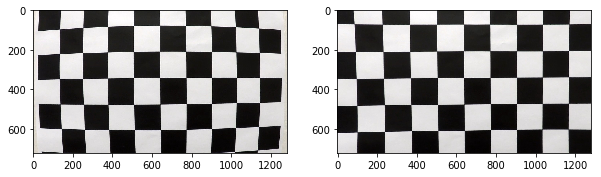

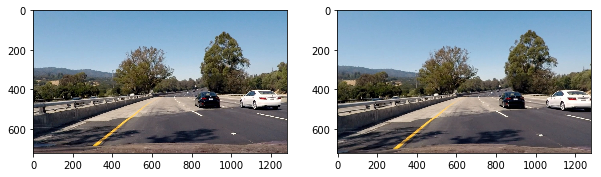

In [10]:
# record an example of image calibration transform

print("Distortion correction example:")
img = Image(path="camera_cal/calibration1.jpg")
_ = camera.correct_distortion(img, savepath="output_images/calibration1_undist.jpg")

img = Image(path="test_images/test4.jpg")
_ = camera.correct_distortion(img, savepath="output_images/test4_undist.jpg")

Perspective correction example:


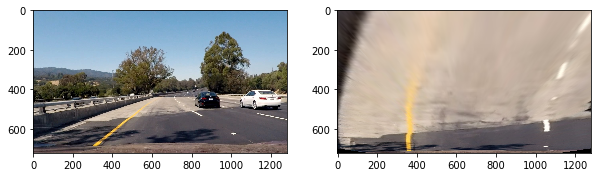

Perspective correction example:


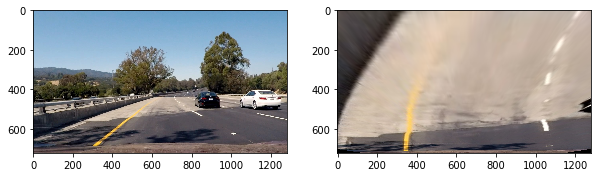

In [4]:
# record an examples of image perspective correction

# use rel perspective with offset
src = np.float32([[0.15,1.0], [0.85,1.0], 
                  [0.47,0.62], [0.53,0.62]])
camera.set_perspective_rel(src, offsetx=0.24)
print("Perspective correction example:")
img = Image(path="test_images/test4.jpg")
_ = camera.unwarp(img, savepath="output_images/test4_.jpg")


# use abs perspective
offset = 290
src = np.float32([[195,720], [1085,720], 
                  [600,440], [685,440]])
dst = np.float32([[offset, camera.height], [camera.width-offset, camera.height],
                  [offset,0], [camera.width-offset,0]])
camera.set_perspective_abs(src, dst)

print("Perspective correction example:")
img = Image(path="test_images/test4.jpg")
_ = camera.unwarp(img, savepath="output_images/test4_.jpg")



Example of image thresholding and perspective correction:


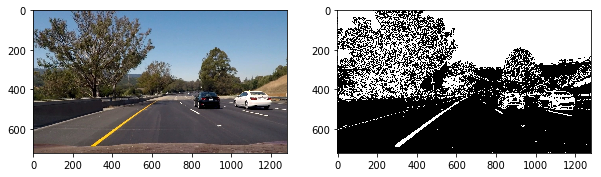

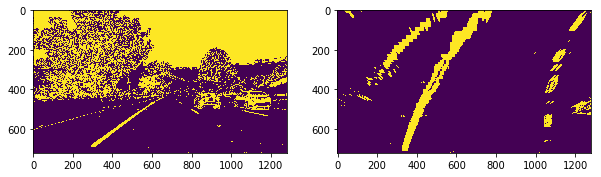

Example of image perspective correction + thresholding:


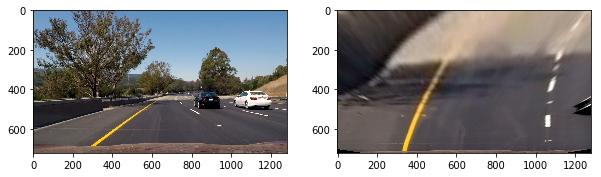

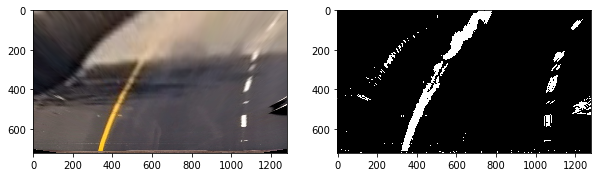

Example of image perspective correction + thresholding:


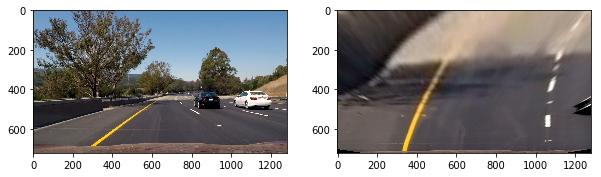

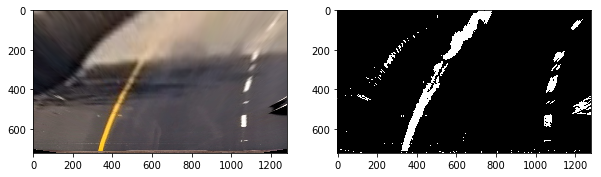

In [5]:
# record an instance of thresholding and perspective correction

print("Example of image thresholding and perspective correction:")
img = Image(path="test_images/test6.jpg")
thrsh = camera.threshold_or(img, savepath="output_images/test6_thrsh.jpg",
                            absx_thresh=(20,100), hls_thresh=(90,255))
_ = camera.unwarp(thrsh, savepath="output_images/test6_thrsh_unwarp.jpg")

print("Example of image perspective correction + thresholding:")
img = Image(path="test_images/test6.jpg")
unwarp = camera.unwarp(img, savepath="output_images/test6_unwarp.jpg")
_ = camera.threshold_or(unwarp, 
                        savepath="output_images/test6_unwarp_thrsh.jpg",
                        absx_thresh=(20,100), 
                        hls_thresh=(90,255))

print("Example of image perspective correction + thresholding:")
img = Image(path="test_images/test6.jpg")
unwarp = camera.unwarp(img, savepath="output_images/test6_unwarp.jpg")
_ = camera.threshold_or(unwarp, 
                        savepath="output_images/test6_unwarp_thrsh.jpg",
                        absx_thresh=(20,150),
                        #mag_thresh=(40, 150),
                        hls_thresh=(90,255))


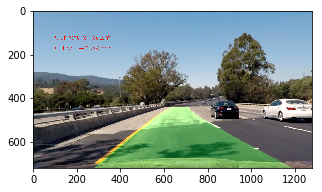

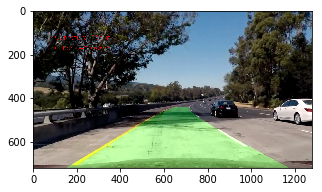

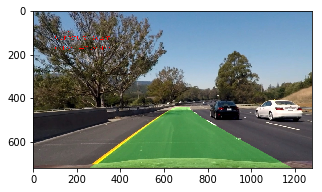

[MoviePy] >>>> Building video track_and_mark_lanes_project_video_output.mp4
[MoviePy] Writing video track_and_mark_lanes_project_video_output.mp4


100%|█████████▉| 1260/1261 [02:21<00:00,  9.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: track_and_mark_lanes_project_video_output.mp4 

CPU times: user 3min 8s, sys: 34.9 s, total: 3min 43s
Wall time: 2min 22s


In [15]:
processing="track_and_mark_lanes"
image=True
video="project_video" #"challenge_video" 

images=[Image(path="test_images/test4.jpg"),
        Image(path="test_images/test5.jpg"), 
        Image(path="test_images/test6.jpg")]
line = Line(camera)

_fns = {
    "unwarp": line.unwarp,
    "fit_lane_poly": line.fit_lane_poly,
    "use_last_lane_poly": line.use_last_lane_poly,
    "track_and_mark_lanes": line.track_and_mark_lanes
}

fn = _fns[processing]
idx = 0
for img in images:
    if image:
        idx += 1
        transformed = fn(img.image)
        fig = plt.figure(figsize = (5, 5))
        plt.imshow(transformed)
        plt.show()
        fig.savefig("output_images/process_{}_{}.jpg".format(idx, processing))



        
#src = np.float32([[0.25,1.0], [0.75,1.0], 
#                  [0.47,0.64], [0.53,0.64]])
#camera.set_perspective_rel(src, offsetx=0.24)

out = line.process_clip('{}.mp4'.format(video), process_image=fn)
%time out.write_videofile(processing+'_'+video+'_output.mp4', audio=False)